# GFS to Parquet for Querying with Amazon Athena

In [1]:
import boto3
from botocore.handlers import disable_signing
from datetime import datetime, timedelta
import xarray as xr
import numpy as np
from pyarrow import float32, float64, int32, schema, Table
from pyarrow import parquet as pq
from pyathena import connect
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Lets convert the 12Z run from July 27th, 2020. We will work with the 0.25 degree spatial resolution files.
# Lets list all of the files here first, keeping just the grib files 

s3 = boto3.client("s3")
paginator = s3.get_paginator('list_objects_v2')
page_iterator = paginator.paginate(Bucket = 'noaa-gfs-bdp-pds', Prefix = 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.')

all_files = [file['Key'] for page in page_iterator for file in page['Contents'] if '.idx' not in file['Key'] and '.anl' not in file['Key']]
all_files

['gfs.20200727/12/gfs.t12z.pgrb2.0p25.f000',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f001',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f002',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f003',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f004',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f005',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f006',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f007',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f008',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f009',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f010',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f011',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f012',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f013',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f014',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f015',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f016',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f017',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f018',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f019',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f020',
 'gfs.20200727/12/gfs.t12z.pgrb2.0p25.f021',
 'gfs.2020

## Function for downloading a single variable from the grib2 files

We use S3 range gets and the grib index files to only download the variable that we care about

In [3]:
def download_variable(key, bucket='noaa-gfs-bdp-pds', variable=':TMP:2 m above ground:', file='/tmp/gfs.grib'):
    s3 = boto3.client('s3')
    resp = s3.get_object(Bucket=bucket, Key=key + '.idx')
    index_data = resp['Body'].read().decode()
    byte_start = 0
    byte_end = 0
    index_lines = index_data.split('\n')
    var_indices = [i for i, s in enumerate(index_lines) if variable in s]
    if len(var_indices) == 0:
        print("Your variable {} was not found in the index file!".format(variable))
    if len(var_indices) > 1:
        print("Your variable {} was found multiple times in the index file. Try narrowing down your search!".format(variable))
    index_start = var_indices[0]
    index_end = index_start + 1
    byte_start = index_lines[index_start].split(':')[1]
    byte_end = index_lines[index_end].split(':')[1]
    resp = s3.get_object(Bucket=bucket, Key=key, Range='bytes={}-{}'.format(byte_start, byte_end))
    with open(file, 'wb') as f:
        f.write(resp['Body'].read())

## Function to convert a GFS object to parquet keeping only the air temperature at 2-m

This converts the file from a grib2 to parquet. We grab only the variable we care about and store it in the resulting parquet file but you could add more variables as needed. We store the run_date and forecast_hour in the resulting object key stored on S3 so that it can be used as a partition for Athena.

In [4]:
def convert_to_parquet(key, parquet_bucket='gfs-parquet'):
    fields = [
            ('i', int32()),
            ('j', int32()),
            ('longitude', float32()),
            ('latitude', float32()),
            ('t2m', float32())
        ]
    schema_parquet = schema(fields)
    
    file = '/tmp/gfs.grib'
    download_variable(key, file=file)
    ds = xr.open_dataset(file, engine='cfgrib')
    date64 = ds['time'].values
    date = (date64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    date = datetime.utcfromtimestamp(date)
    run_date = f"{date:%Y-%m-%d-%H}"
    forecast_hour = key[-3:]
    date_valid = date + timedelta(hours=float(forecast_hour))
    valid_date = f"{date_valid:%Y-%m-%d-%H}"
    x_orig = ds.variables['longitude'].values[:]
    y_orig = ds.variables['latitude'].values[:]
    x = ds.variables['longitude'].values[:]
    y = ds.variables['latitude'].values[:]
    yT = y[np.newaxis].T
    y = np.hstack([yT for num in range(x_orig.size)])
    x = np.vstack([x for num in range(y_orig.size)])
    i = np.arange(x_orig.size)
    j = np.arange(y_orig.size)
    jT = j[np.newaxis].T
    j = np.hstack([jT for num in range(x_orig.size)])
    i = np.vstack([i for num in range(y_orig.size)])
    
    output = f"/tmp/data.pq"
    outputKey = f"run={run_date}/f={forecast_hour}/data.pq"
    
    with pq.ParquetWriter(output, schema_parquet, compression="GZIP") as pw:
        data_dict = {
            'i': np.copy(i.flatten()),
            'j': np.copy(j.flatten()),
            'longitude': np.copy(x.flatten()),
            'latitude': np.copy(y.flatten()),
            't2m': np.copy(ds.variables['t2m'].values[:].flatten())
        }
        table = Table.from_pydict(data_dict, schema_parquet)
        pw.write_table(table)
        
    boto3.resource("s3").Bucket(parquet_bucket).upload_file(output, outputKey)
    
    return (ds, run_date, valid_date)

## Do the actual conversion here for our files. Just do the first 72 hours for the sake of time

In [ ]:
all_files = all_files[:72]
for file in all_files:
    convert_to_parquet(file)


## Query with Athena. First we will set up the table

In [5]:
athena_data_bucket = "gfs-parquet-demo-bucket"
conn = connect(s3_staging_dir="s3://" + athena_data_bucket,
               region_name="us-east-1")

In [6]:
table = """
CREATE EXTERNAL TABLE IF NOT EXISTS gfs (
  `i` int,
  `j` int,
  `longitude` float,
  `latitude` float,
  `t2m` float
 )
 PARTITIONED BY ( 
  `run_date` string,
  `forecast_hour` int)
STORED AS PARQUET
LOCATION 's3://gfs-parquet/'
TBLPROPERTIES (
  'projection.enabled'='true', 
  'projection.run_date.format'='yyyy-MM-dd-HH', 
  'projection.run_date.interval'='1', 
  'projection.run_date.interval.unit'='HOURS', 
  'projection.run_date.range'='NOW-1DAYS,NOW', 
  'projection.run_date.type'='date', 
  'projection.forecast_hour.range'='00,72', 
  'projection.forecast_hour.type'='integer',
  'projection.forecast_hour.digits'='3',
  'storage.location.template'='s3://gfs-parquet/run=${run_date}/f=${forecast_hour}/')
"""

cursor = conn.cursor()
cursor.execute(table)
print(cursor.fetchall())

[]


## Query for our data

In [7]:
#Plug in the lat lon here, rounded to nearest 0.5. This is for Chicago
lat = 42.0
lon = -87.5
# Longitude is stored in the model from 0-360. So convert our negative longitudes 
if lon < 0:
    lon = 360 + lon
df = pd.read_sql(f"SELECT t2m, date_parse(run_date, '%Y-%m-%d-%H') as run, date_add('hour',forecast_hour,date_parse(run_date, '%Y-%m-%d-%H')) as valid FROM gfs where latitude = {lat} and longitude = {lon} order by forecast_hour asc", conn)

In [8]:
# Convert temperature from Kelvin to degrees F
df['t2m'] = (df['t2m'] - 273.15) * 9/5 + 32

In [9]:
df

,t2m,run,valid
0,76.190000,2020-07-27 12:00:00,2020-07-27 12:00:00
1,75.660206,2020-07-27 12:00:00,2020-07-27 13:00:00
2,76.226666,2020-07-27 12:00:00,2020-07-27 14:00:00
3,77.116460,2020-07-27 12:00:00,2020-07-27 15:00:00
4,77.632304,2020-07-27 12:00:00,2020-07-27 16:00:00
...,...,...,...
67,73.490000,2020-07-27 12:00:00,2020-07-30 07:00:00
68,73.157540,2020-07-27 12:00:00,2020-07-30 08:00:00
69,73.309964,2020-07-27 12:00:00,2020-07-30 09:00:00
70,73.535900,2020-07-27 12:00:00,2020-07-30 10:00:00


Text(0, 0.5, 'Temperature (F)')

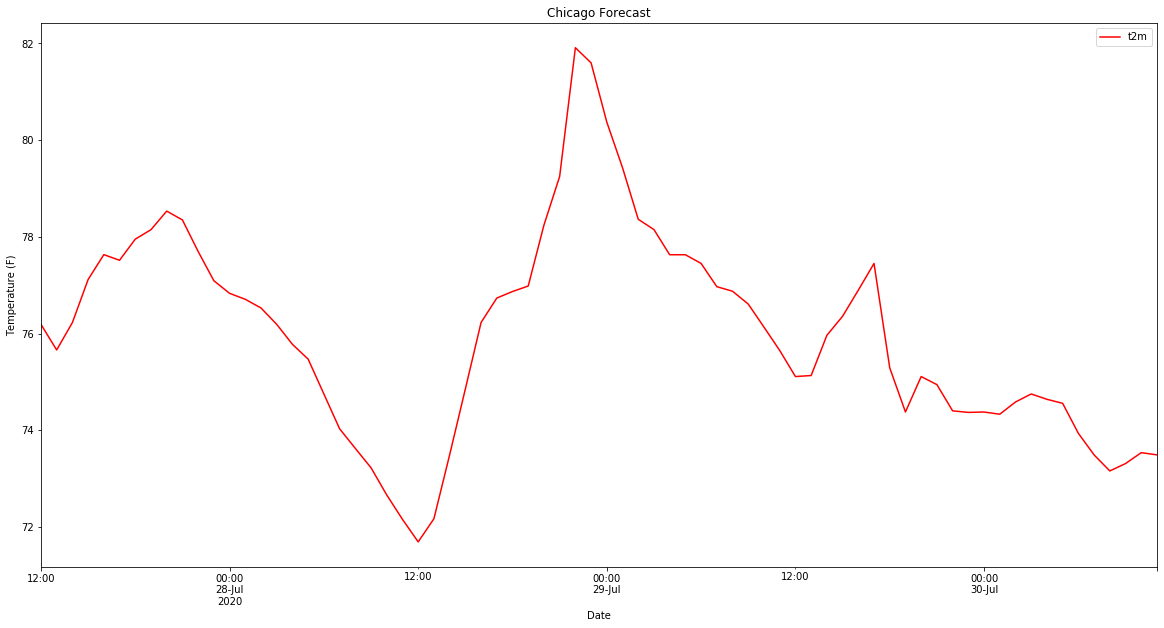

In [10]:
ax = plt.gca()
df.plot(figsize=(20,10), title='Chicago Forecast', kind='line', x='valid', y='t2m', color='red', ax=ax)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')